2) This code is created using the following <a href="https://www.youtube.com/watch?v=7u83l_HqamI&ab_channel=DigitalSreeni"> video tutorial</a>.

3) In addition, this <a href="https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20_image_segmentation/11_voronoi_otsu_labeling.html">source</a> was very useful to properly understand the main algorithm her.

### Import necessary libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, io, img_as_ubyte
from skimage.color import rgb2hed, hed2rgb
from skimage.exposure import rescale_intensity

import [pyclesperanto_prototype] as cle #main algorithm is HERE!!!

import pandas as pd
from glob import glob

In [26]:
img_dir = '../data/morphology_data/'
images = glob(img_dir + "*tif")

### Convert RGB into HED (to find only brown cells)

In [147]:
def color_separate(ihc_rgb):
    ihc_hed = rgb2hed(ihc_rgb)
    null = np.zeros_like(ihc_hed[:, :, 0])
    ihc_h = img_as_ubyte(hed2rgb(np.stack((ihc_hed[:,:,0], null, null), axis = -1)))
    ihc_e = img_as_ubyte(hed2rgb(np.stack((null, ihc_hed[:,:,1], null), axis = -1)))
    ihc_d = img_as_ubyte(hed2rgb(np.stack((null, null, ihc_hed[:,:,2]), axis = -1)))

    h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1),
                            in_range = (0, np.percentile(ihc_hed[:,:,0], 99)))
    d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1),
                            in_range = (0, np.percentile(ihc_hed[:,:,2], 99)))

    zdh = img_as_ubyte(np.dstack((null, d, h)))
    return [ihc_h, ihc_e, ihc_d, zdh]

In [148]:
new_img = img_dir+'L10-1 Cryo Exp 16 ms Gain 1 Satur 100 WB.tif'
ihc_rgb = io.imread(new_img)
ihc_rgb = ihc_rgb[:int(ihc_rgb.shape[0]/3), :int(ihc_rgb.shape[1]/3), :]

In [149]:
channels = color_separate(ihc_rgb)

In [150]:
def image_plot(channels, ihc_rgb):
    fig, axs = plt.subplots(1,4)
    fig.set_dpi(200)
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    axs[3].axis('off')
    axs[0].title.set_text('Original')
    axs[1].title.set_text('H')
    axs[2].title.set_text('E')
    axs[3].title.set_text('D')
    axs[0].imshow(ihc_rgb)
    axs[1].imshow(channels[0])
    axs[2].imshow(channels[1])
    axs[3].imshow(channels[2])

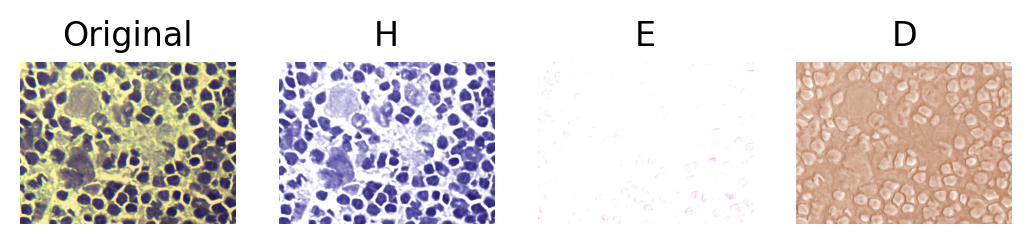

In [151]:
image_plot(channels, ihc_rgb)

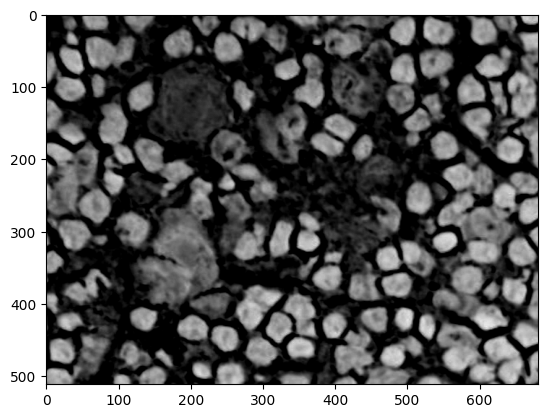

In [152]:
# Make dark background and bright cells
input_image = np.invert(channels[0][:, :, 2])
plt.imshow(input_image, cmap='gray')

### Main algorithm for image segmentation

In [159]:
# device = cle.select_device(cle.available_device_names(dev_type='gpu')[0])
# device
# input_gpu = cle.push(input_image)
input_gpu = input_image

#IMPORTANT PARAMETERS THAT CAN BE TUNED BY USER
sigma_spot_detection = 10
sigma_outline = 1


segmented = cle.voronoi_otsu_labeling(input_gpu, spot_sigma=sigma_spot_detection, 
                                      outline_sigma=sigma_outline)

statistics = cle.statistics_of_labelled_pixels(input_gpu, segmented) 
table = pd.DataFrame(statistics)   

In [160]:
label_outlines = cle.detect_label_edges(segmented)

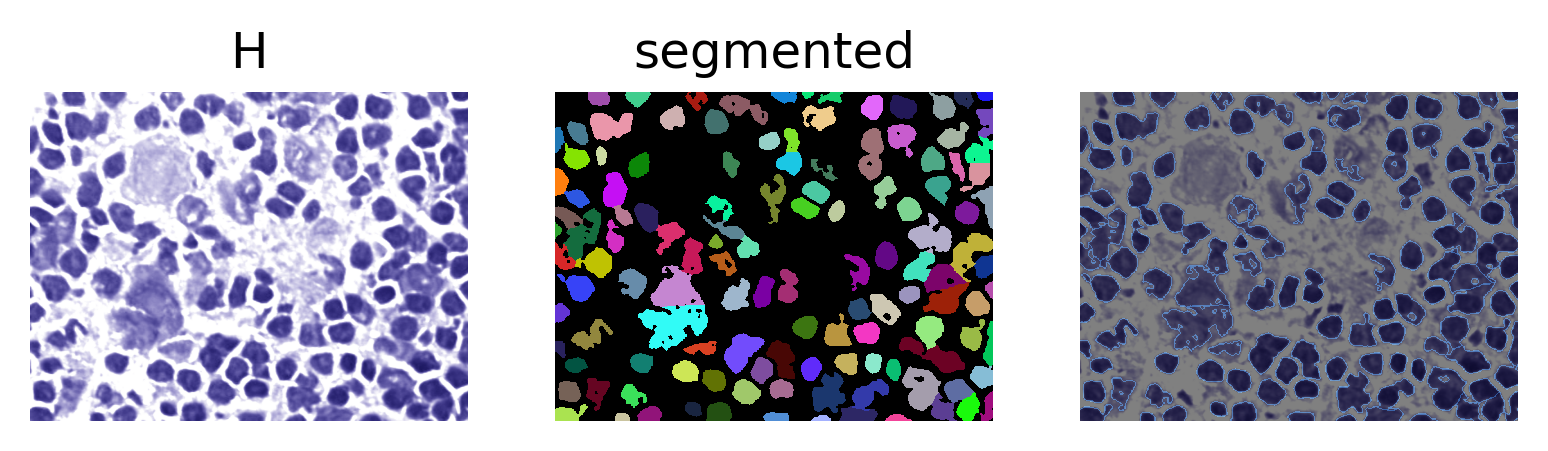

In [162]:
fig, axs = plt.subplots(1,3)
fig.set_dpi(300)
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[0].title.set_text('H')
axs[1].title.set_text('segmented')
axs[0].imshow(channels[0])
cle.imshow(segmented, labels=True, plot=axs[1])
axs[2].imshow(channels[0])
cle.imshow(label_outlines, labels=True, plot=axs[2], alpha = 0.5)